# <div style="text-align: center"> Implementation of Fuzzy Logic Disparity Mapping </div>
<div style="text-align: center"> EE367
<br>
<br>
<div style="text-align: center"> Stanford University Winter 2021 </div>
<br>
<div style="text-align: center"> Erick Blankenberg </div>

---

Original paper [here](https://research.ijcaonline.org/volume113/number2/pxc3901572.pdf).

Fuzzy logic calculations.

In [15]:
import numpy as np

ruleTable = [[2, 2,    None, 2], # Rows are [Correlation, D1, D2, Output] and number is category 0: Bad, 1: Medium, 2: Good, None: Don't-care
             [2, 1,    None, 2],
             [2, 0,    None, 1],
             [1, 2,    None, 1],
             [1, 1,    None, 0],
             [1, 0,    None, 1], 
             [0, 2,    None, 1], 
             [0, 1,    None, 1], 
             [0, 0,    None, 0], 
             [2, None, 2,    2], 
             [2, None, 1,    1], 
             [2, None, 0,    1], 
             [1, None, 2,    0], 
             [1, None, 1,    1], 
             [1, None, 0,    1], 
             [0, None, 2,    1], 
             [0, None, 1,    0], 
             [0, None, 0,    0]]

# Input is an [rows, columns] array corresponding to one feature input. Output is quality class
def featuresToFLogicClasses(featureInput, alpha = 0, gamma = 0.5, phi = 1):
    inputShape = featureInput.shape
    outFeatures = np.zeros((inputShape[0], inputShape[1], 3))
    
    # Class "Good":
    locsClassGood_1 = featureInput < alpha
    locsClassGood_2 = (alpha <= featureInput) * (featureInput <= gamma)
    outFeatures[locsClassGood_1, 2] = 1
    outFeatures[locsClassGood_2, 2] = (featureInput[locsClassGood_2] - gamma) / (alpha - gamma)
    
    # Class "Medium":
    locsClassMedium_1 = (alpha <= featureInput) * (featureInput <= gamma)
    locsClassMedium_2 = (gamma <= featureInput) * (featureInput <= phi)
    outFeatures[locsClassMedium_1, 1] = (featureInput[locsClassMedium_1] - alpha) / (gamma - alpha)  
    outFeatures[locsClassMedium_2, 1] = (featureInput[locsClassMedium_2] - phi) / (gamma - phi)
    
    # Class "Bad":
    locsClassBad_1 = (gamma <= featureInput) * (featureInput < phi)
    locsClassBad_2 = (featureInput >= phi)
    outFeatures[locsClassBad_1, 0] = (featureInput[locsClassBad_1] - gamma) / (phi - gamma)
    outFeatures[locsClassBad_2, 0] = 1
    
    return outFeatures
    
# Evaluates antecedants according to rule table given on page 4 table 1 (AND between all)
# > Argument stackedFeatureLogicClasses is an array [logicClasses_Correlation, logicClasses_D1, logicClasses_D2]
def flogicClassesToRuleAntecedant(stackedFeatureLogicClasses):
    numRules        = len(ruleTable)
    logicClassShape = stackedFeatureLogicClasses[0].shape
    outAntecedants  = np.ones((logicClassShape[0], logicClassShape[1], numRules))
    for currentRuleIndex in range(numRules):
        for currentFeatureValue in range(len(ruleTable[0]) - 1):
            targetClass = ruleTable[currentRuleIndex][currentFeatureValue]
            if(targetClass is not None):
                outAntecedants[:, :, currentRuleIndex] = np.minimum(outAntecedants[:, :, currentRuleIndex], stackedFeatureLogicClasses[currentFeatureValue][:, :, targetClass])
    
    return outAntecedants

# Find outcome of rule assuming simplified Mamdani operator 
def AntecedantsToFuzzyOutput(antecedants, outRho = 0.4, outSigma = 0.6, outAlpha = 0.0, outGamma = 0.5, outPhi = 1.0):
    numRules        = len(ruleTable)
    antecedantShape = antecedants.shape
    outputs         = np.zeros((antecedantShape[0], antecedantShape[1]))
    
    ruleWidths   = np.zeros(numRules)
    ruleCenters  = np.zeros(numRules)
    ruleToWidth  = [outGamma, outSigma - outRho, 1 - outGamma];
    ruleToCenter = [outGamma / 2.0, (outSigma - outRho) / 2.0, (1 - outGamma) / 2.0];
    for currentRule in range(numRules):
        ruleWidths[currentRule]  = ruleToWidth[ruleTable[currentRule][-1]]
        ruleCenters[currentRule] = ruleToCenter[ruleTable[currentRule][-1]]
    
    for currentRow in range(antecedantShape[0]):
        for currentCol in range(antecedantShape[1]):
            volumes = antecedants[currentRow, currentCol] * ruleWidths
            outputs[currentRow, currentCol] = np.sum(volumes * ruleCenters) /  np.sum(volumes) 

    return outputs



# TODO Find outcome of rule assuming traditional Mamdani operator is applied

def featuresToDisparity(correlation, leftEdge, rightEdge):
    disparities = np.zeros_like(correlation)
    for currentS in range(correlation.shape[2]):
        classCorr  = featuresToFLogicClasses(correlation[:, :, currentS])
        classLeft  = featuresToFLogicClasses(leftEdge[:, :, currentS])
        classRight = featuresToFLogicClasses(rightEdge[:, :, currentS])
        antecedants = flogicClassesToRuleAntecedant([classCorr, classLeft, classRight])
        disparities[:, :, currentS] = AntecedantsToFuzzyOutput(antecedants)
        
    indices     = np.argmax(disparities, 2)
    confidences = disparities[:, :, indices]
    return (indices, confidences)
    

Test to make sure that the fuzzy logic system works as expected.

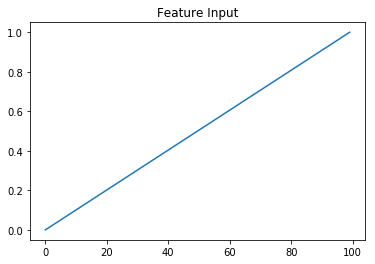

1


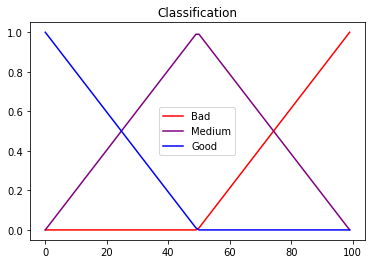

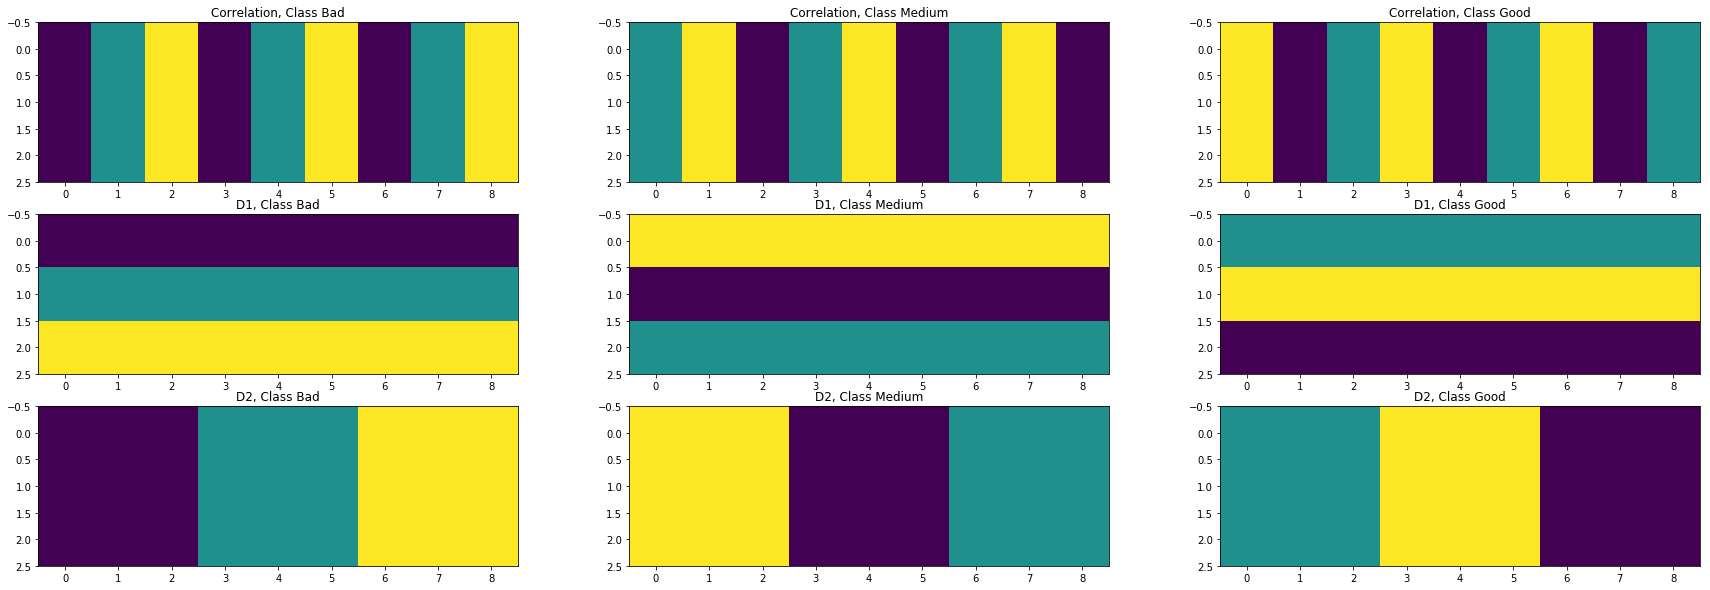

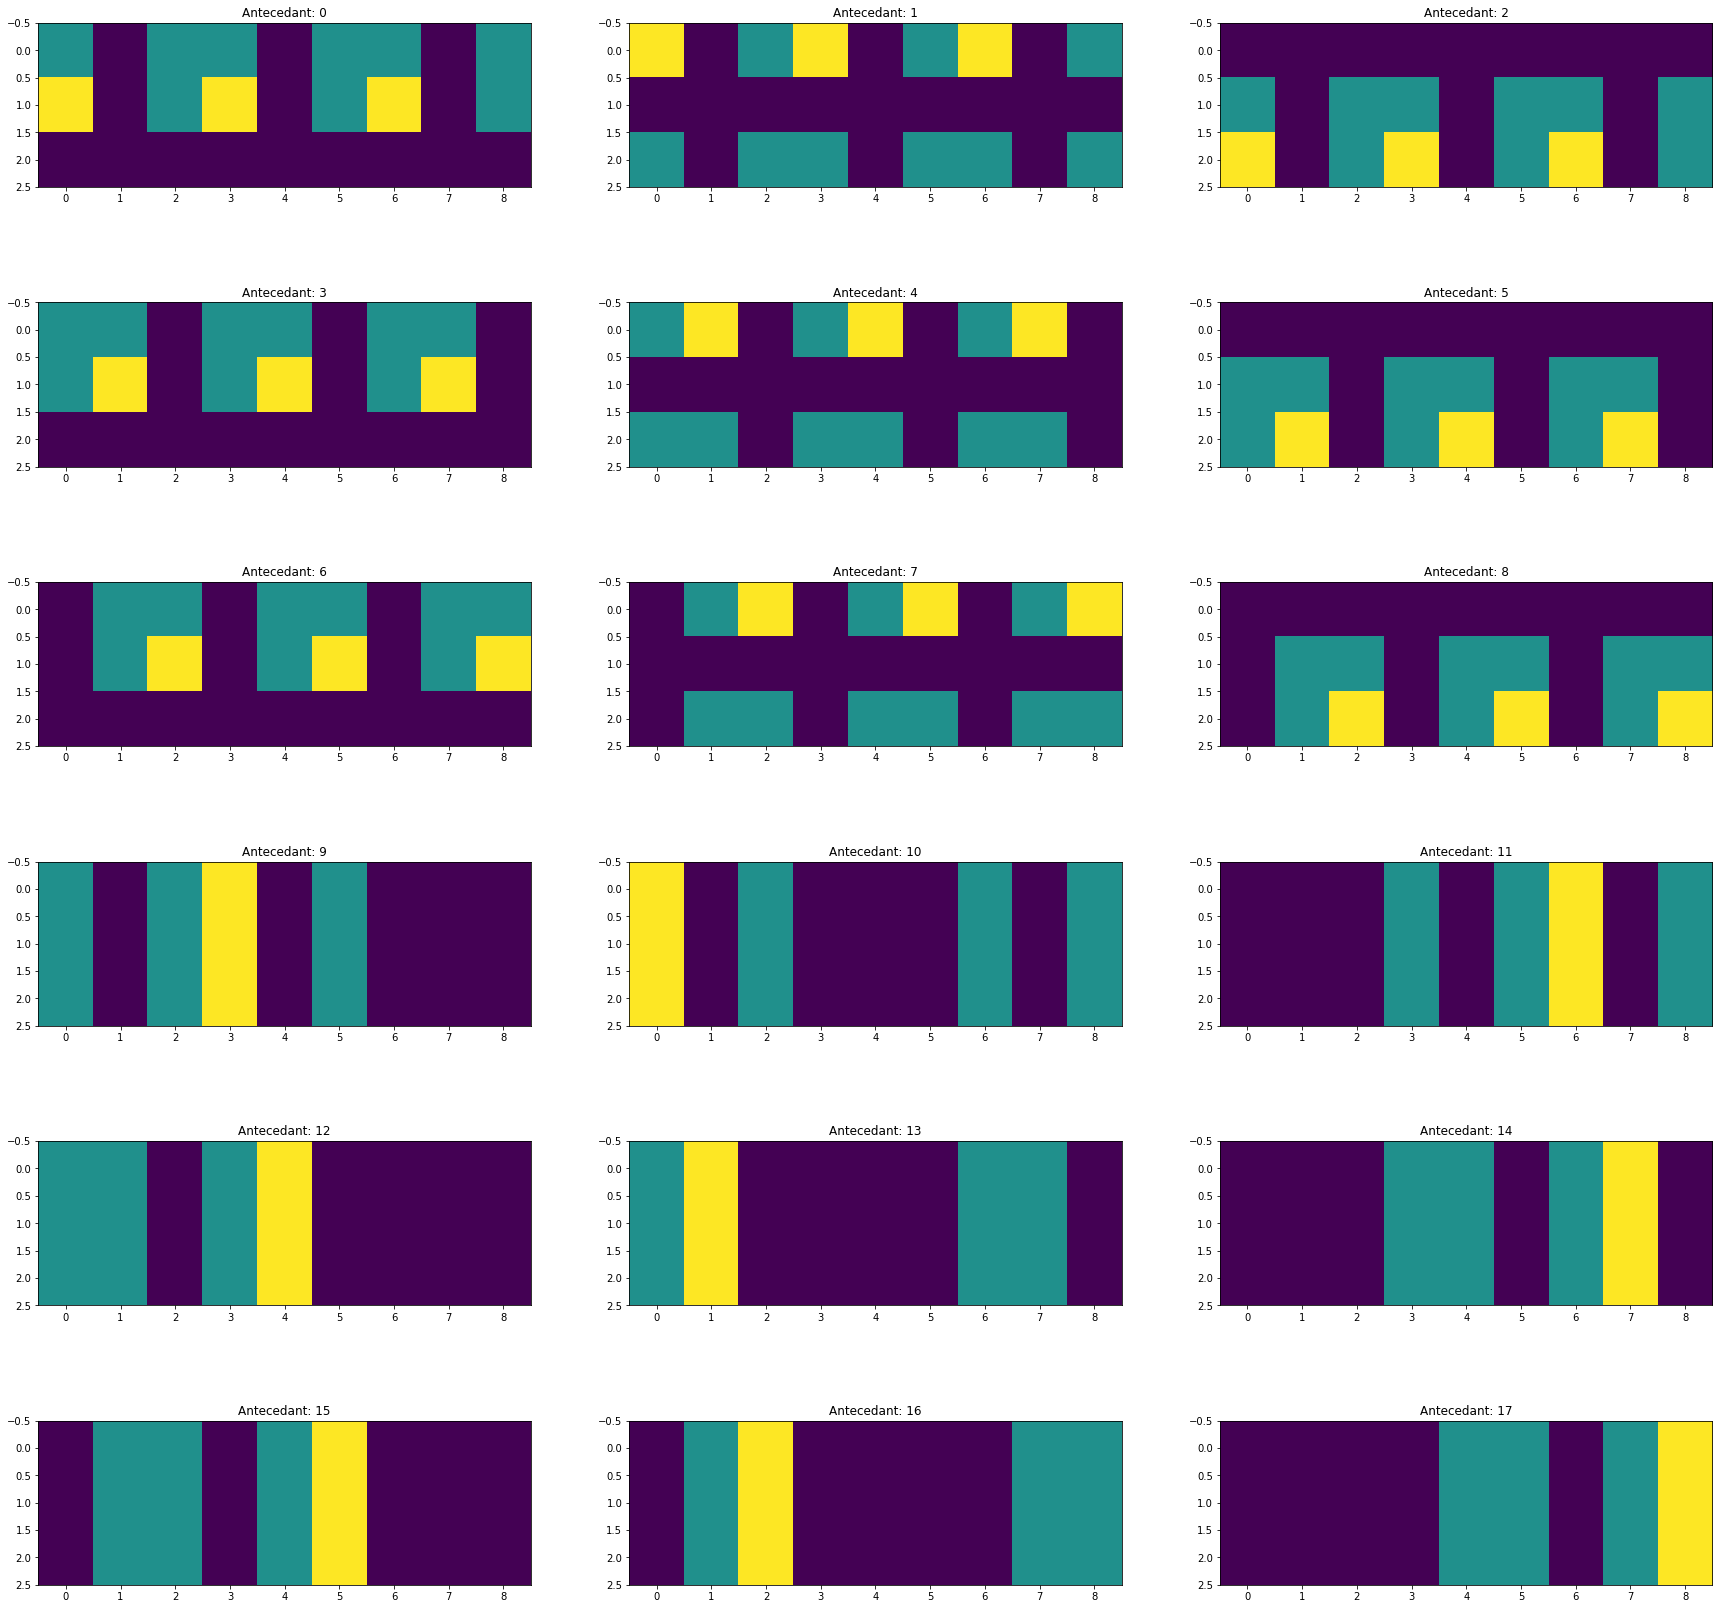

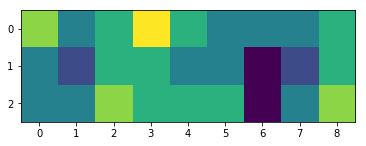

In [99]:
import matplotlib.pyplot as plt

# Classification test 
testDimensions = 100

features_1       = np.zeros((testDimensions, testDimensions))
features_1[0, :] = np.linspace(0, 1, testDimensions)

plt.figure()
plt.plot(features_1[0, :])
plt.title("Feature Input")
plt.show()

classes_1 = featuresToFLogicClasses(features_1, 0, 0.5, 1)

plt.figure()
plt.plot(classes_1[0, :, 0], label = "Bad", color = "red")
plt.plot(classes_1[0, :, 1], label = "Medium", color = "purple")
plt.plot(classes_1[0, :, 2], label = "Good", color = "blue")
plt.title("Classification")
plt.legend()
plt.show()

# Classes to antecedants and antecedants to outputs
testSwatch_f1 = np.zeros((3, 9, 3))
testSwatch_f2 = np.zeros((3, 9, 3))
testSwatch_f3 = np.zeros((3, 9, 3))

# > Correlation
for currentColIndex in range(9):
    testSwatch_f1[:, currentColIndex, 0] = 0.25 * ((currentColIndex % 3) + 1)
    testSwatch_f1[:, currentColIndex, 1] = 0.25 * (((currentColIndex + 1) % 3) + 1)
    testSwatch_f1[:, currentColIndex, 2] = 0.25 * (((currentColIndex + 2) % 3) + 1)
    
# > D1
testSwatch_f2[0, :, 0] = 0.25
testSwatch_f2[1, :, 0] = 0.50
testSwatch_f2[2, :, 0] = 0.75
testSwatch_f2[0, :, 1] = 0.75
testSwatch_f2[1, :, 1] = 0.25
testSwatch_f2[2, :, 1] = 0.50
testSwatch_f2[0, :, 2] = 0.50
testSwatch_f2[1, :, 2] = 0.75
testSwatch_f2[2, :, 2] = 0.25
# > D2
testSwatch_f3[:, 0:3,  0] = 0.25
testSwatch_f3[:, 3:6,  0] = 0.5
testSwatch_f3[:, 6:10, 0] = 0.75
testSwatch_f3[:, 0:3,  1] = 0.75
testSwatch_f3[:, 3:6,  1] = 0.25
testSwatch_f3[:, 6:10, 1] = 0.50
testSwatch_f3[:, 0:3,  2] = 0.50
testSwatch_f3[:, 3:6,  2] = 0.75
testSwatch_f3[:, 6:10, 2] = 0.25

# > Plots
fig, ax = plt.subplots(ncols= 3, nrows= 3, figsize=(30, 10))
numToClassname = ["Bad", "Medium", "Good"]
plt.title("Input Feature Classification Strengths")
for currentCol in range(3):
    ax[0, currentCol].imshow(testSwatch_f1[:, :, currentCol]);
    ax[0, currentCol].set_title("Correlation, Class %s" % numToClassname[currentCol])
    ax[1, currentCol].imshow(testSwatch_f2[:, :, currentCol]);
    ax[1, currentCol].set_title("D1, Class %s" % numToClassname[currentCol])
    ax[2, currentCol].imshow(testSwatch_f3[:, :, currentCol]);
    ax[2, currentCol].set_title("D2, Class %s" % numToClassname[currentCol])

# Antecedant 
# > Calculates
testAntecedants = flogicClassesToRuleAntecedant([testSwatch_f1, testSwatch_f2, testSwatch_f3])
# > Plots
fig, ax = plt.subplots(nrows= 6, ncols= 3, figsize=(30, 30))
plt.title("Output Classification Strength Max")
for currentRow in range(6):
    for currentCol in range(3):
        ax[currentRow, currentCol].imshow(testAntecedants[:, :, (currentRow * 3 + currentCol)])
        ax[currentRow, currentCol].set_title("Antecedant: %d" % (currentRow * 3 + currentCol))
        
# > Rule Evaluation
# > Calculates
testOutputs = AntecedantsToOutput(testAntecedants)
# > Plots
plt.figure()
plt.imshow(testOutputs)

Runs computation on a test image with given input features.

In [6]:
import numpy as np
import skimage.io as io
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
from scipy import signal
from skimage.transform import rescale

# Resizes images so that they fit within the specified bounding box
def standardizedResize(highResImage, maximumDimensions):
    imageSize = highResImage.shape
    imageRowsRescale =  float(maximumDimensions[0]) / float(imageSize[0])
    imageColsRescale = float(maximumDimensions[1]) / float(imageSize[1])
    scaleFactor = min(imageRowsRescale, imageColsRescale)
    out0 = rescale(highResImage[:, :, 0], scaleFactor)
    out1 = rescale(highResImage[:, :, 1], scaleFactor)
    out2 = rescale(highResImage[:, :, 2], scaleFactor)
    return np.stack((out0, out1, out2), 2)


# Computes sum of absolute differences for two greyscale images as a function of shift of the right hand side image
def DisparityFromSAD(imageLeft, imageRight, sMax, wRadius, padMode = 'edge'):
    out = np.zeros((imageLeft.shape[0], imageLeft.shape[1], sMax))
    augmentedRight = np.pad(imageRight, ((wRadius, wRadius), (wRadius, wRadius + sMax)), padMode)
    augmentedLeft  = np.pad(imageLeft, ((wRadius, wRadius), (wRadius, wRadius + sMax)), padMode)
    for currentCenterRow in range(imageLeft.shape[0]):
        for currentCenterCol in range(imageLeft.shape[1]):
            for currentS in range(sMax):
                sampleLeft = augmentedLeft[currentCenterRow:(currentCenterRow + 1 + 2 * wRadius), currentCenterCol:(currentCenterCol + 1 + 2 * wRadius)]
                sampleRight = augmentedRight[currentCenterRow:(currentCenterRow + 1 + 2 * wRadius), (currentCenterCol + currentS):(currentCenterCol + currentS + 1 + 2 * wRadius)]
                out[currentCenterRow, currentCenterCol, currentS] = np.sum(np.sum(np.abs(sampleLeft - sampleRight))) / ((wRadius * 2 + 1)**2)
                
    return out

def SobelGradY(greyscaleImage, padMode = 'same'):
    sobelGradientY = np.transpose([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # TODO WHY DO I HAVE TO BE TRANSPOSED? WHY IS MINIMUM NON-NEGATIVE?
    return signal.convolve2d(greyscaleImage, sobelGradientY, mode = padMode)

def DistanceToLeftEdge(sobelImage, beta = 30.0/255.0):
    out = np.zeros_like(sobelImage)
    thresholdedMag = np.abs(sobelImage) > beta
    for currentRow in range(sobelImage.shape[0]):
        lastEdgeIndex = 0
        for currentCol in range(sobelImage.shape[1]):
            if(thresholdedMag[currentRow, currentCol]):
                lastEdgeIndex = 0
            out[currentRow, currentCol] = lastEdgeIndex
            lastEdgeIndex += 1

    return out

def DisparityForEdgeDistance(imageLeft, imageRight, sMax, padMode = 'edge'):
    sobelImageLeft  = SobelGradY(imageLeft)
    sobelImageRight = SobelGradY(imageRight)
    out = np.zeros((imageLeft.shape[0], imageLeft.shape[1], sMax))
    augmentedRightSobel = np.pad(sobelImageRight, ((0, 0), (0, sMax)), padMode)
    distanceToLeftEdgeLeft = DistanceToLeftEdge(sobelImageLeft)
    for currentS in range(sMax):
        out[:, :, currentS] = np.abs(distanceToLeftEdgeLeft - DistanceToLeftEdge(augmentedRightSobel[:, currentS:(imageLeft.shape[1] + currentS)]))
    
    return out

5
(120, 159, 120, 159)


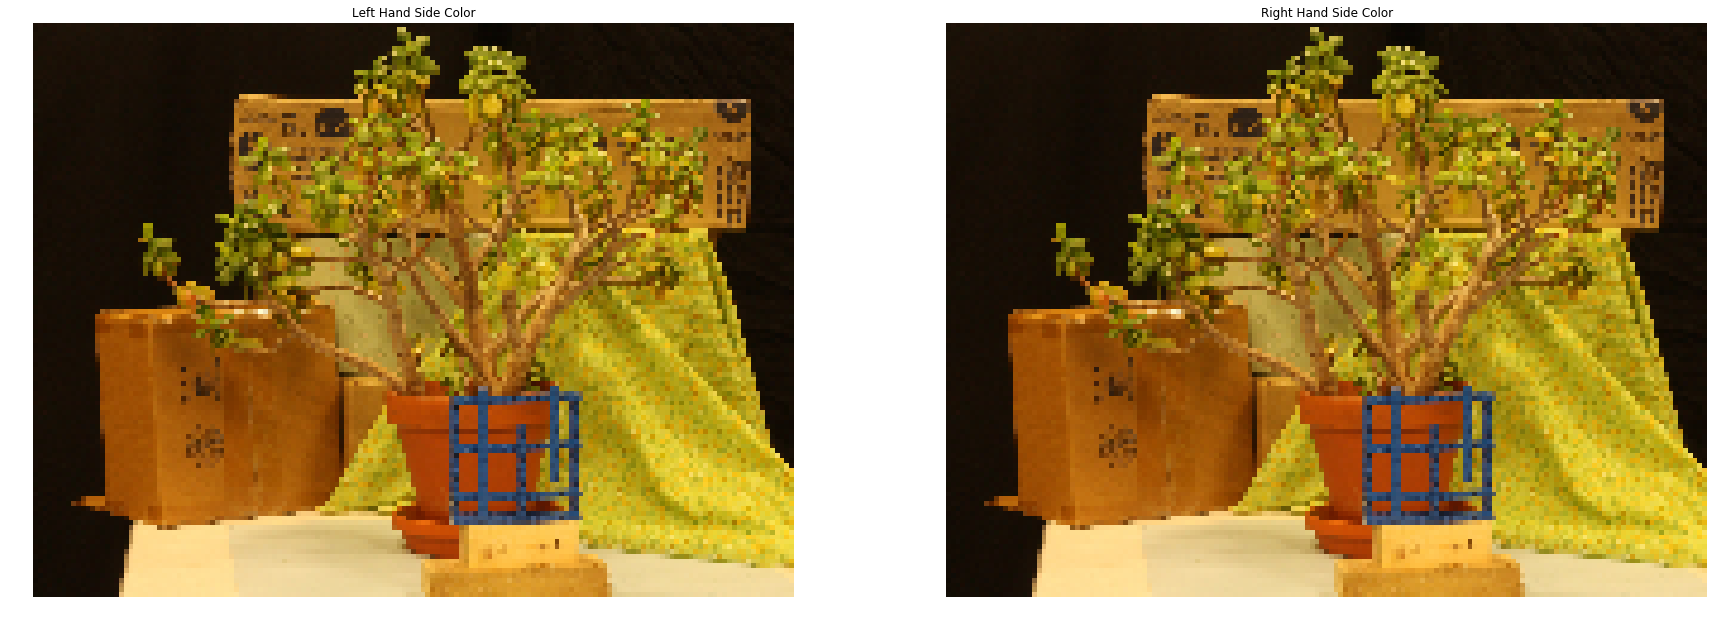

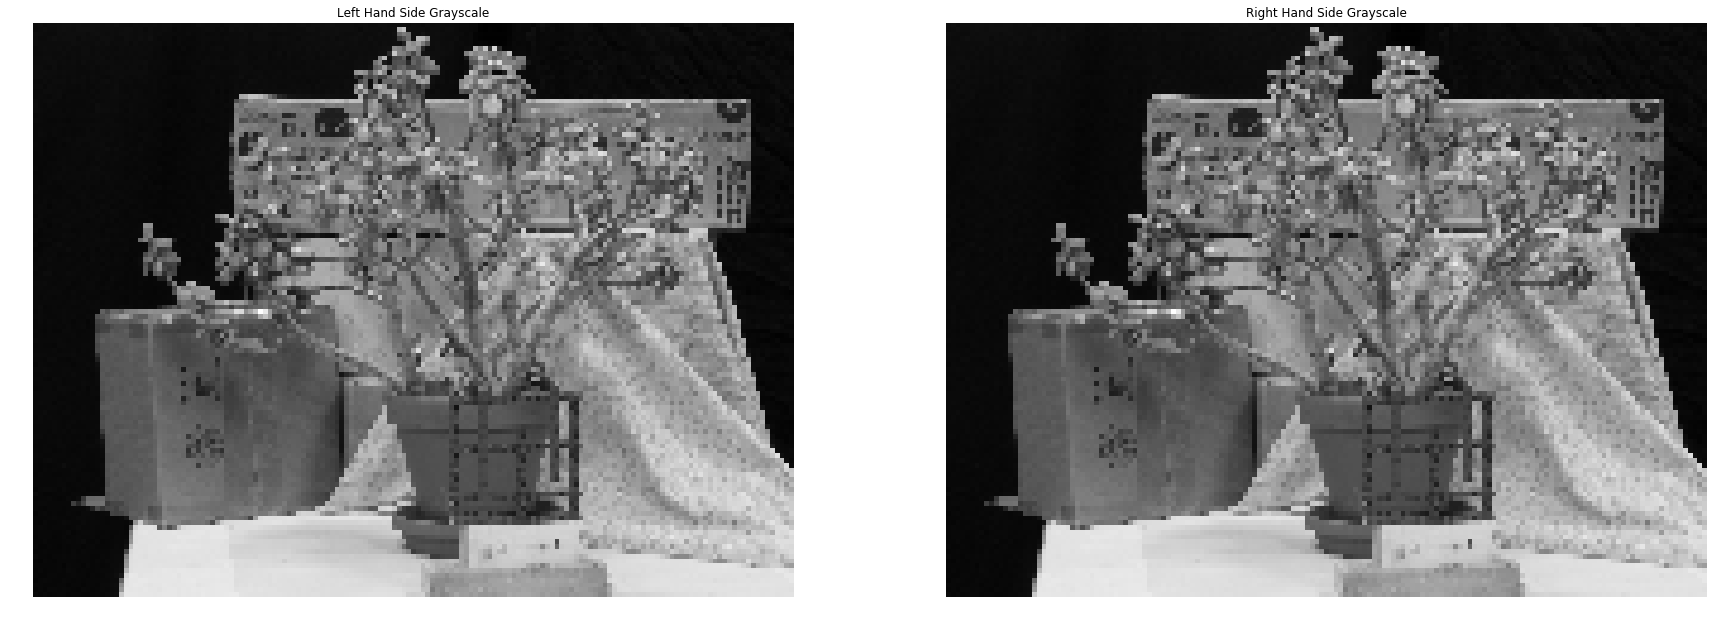

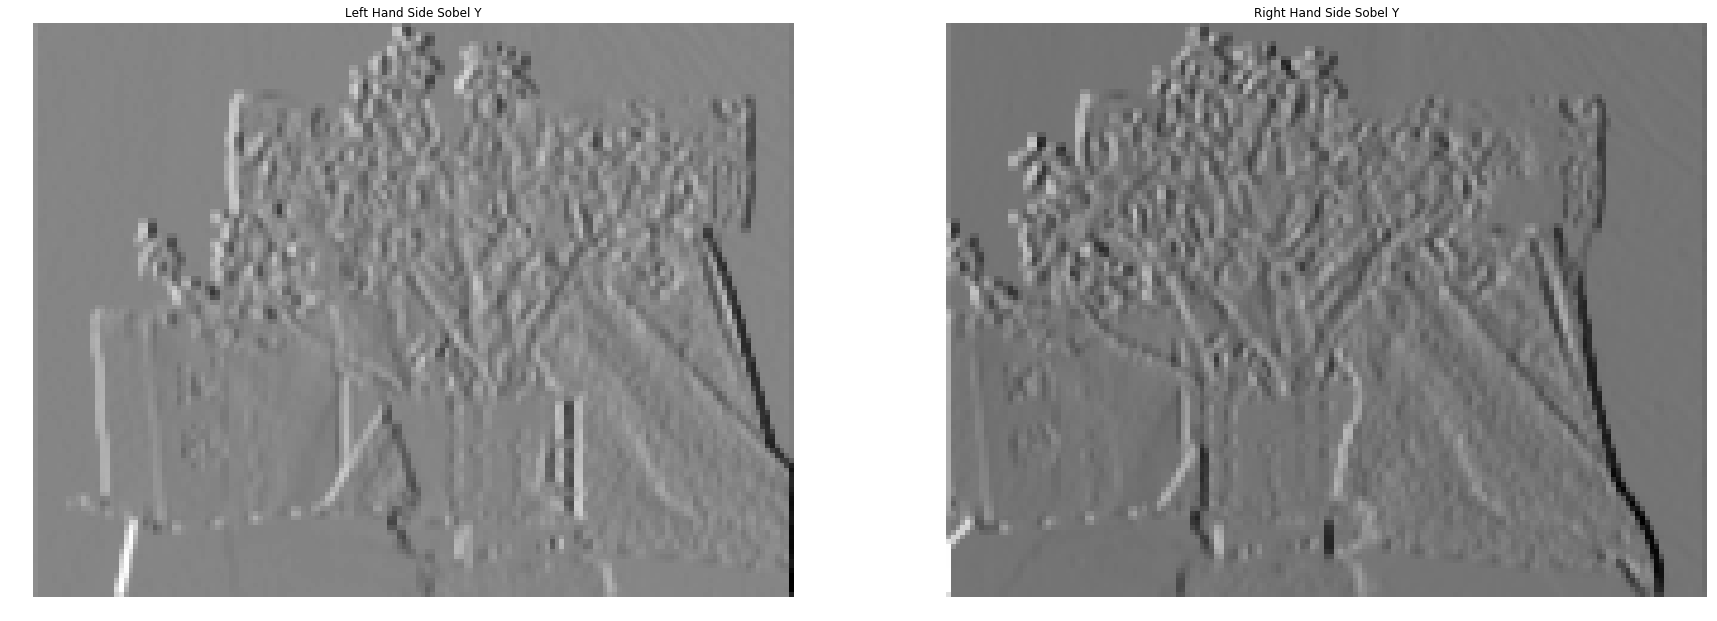

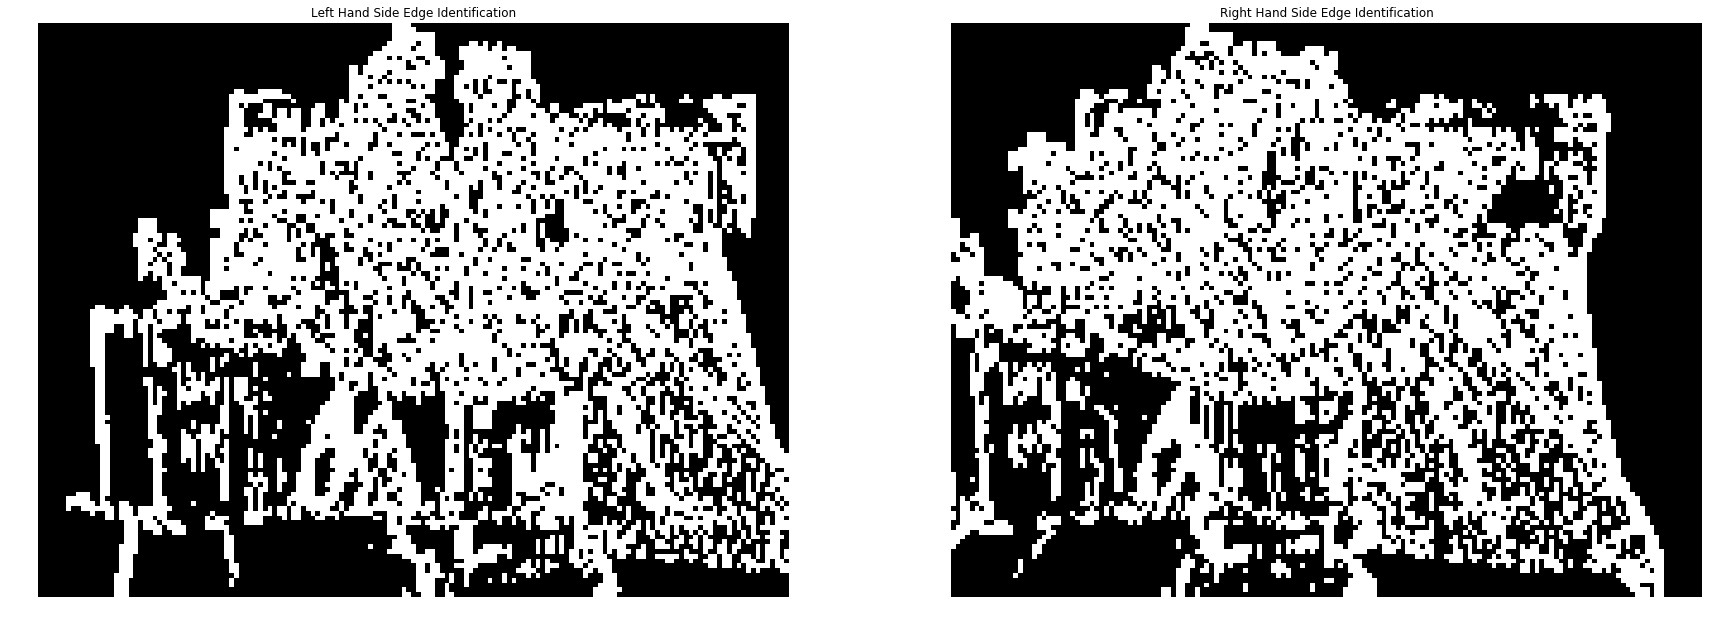

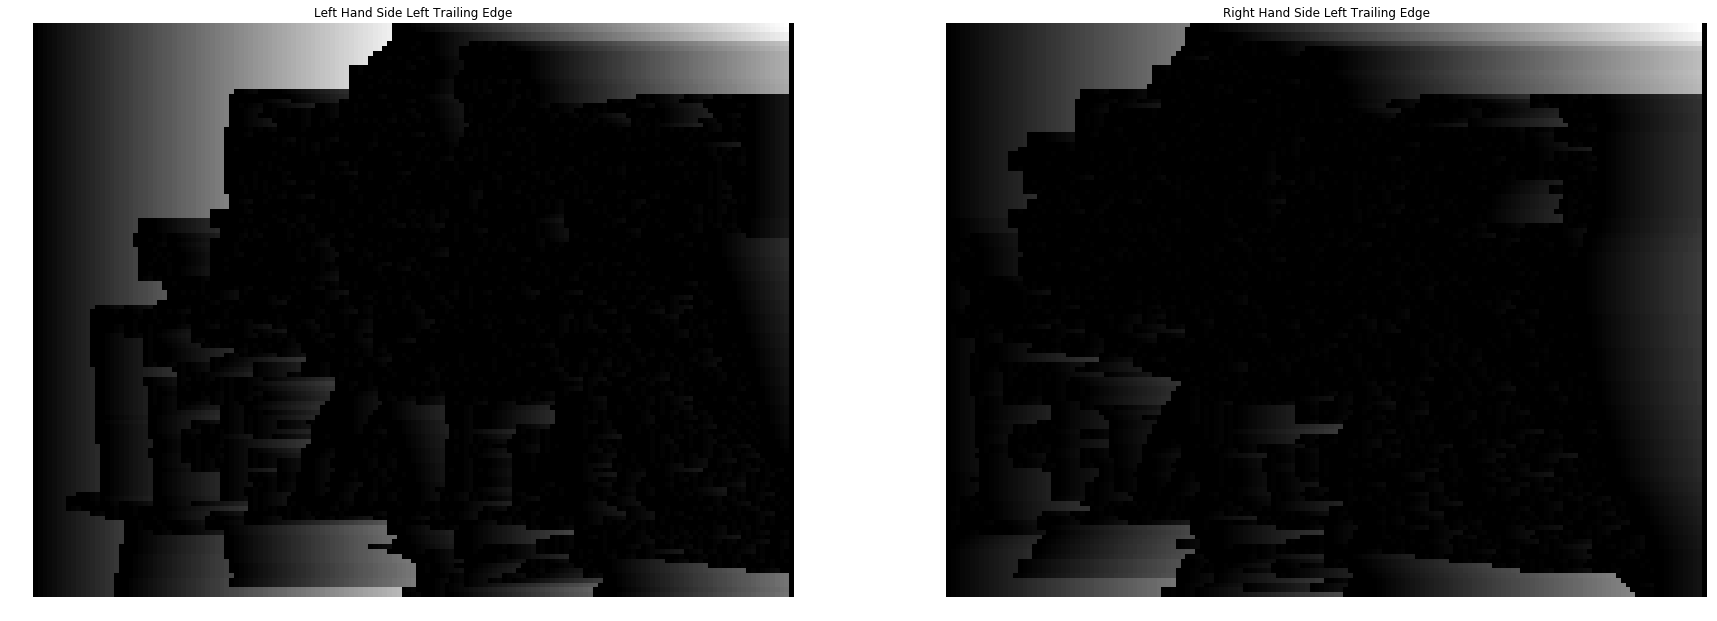

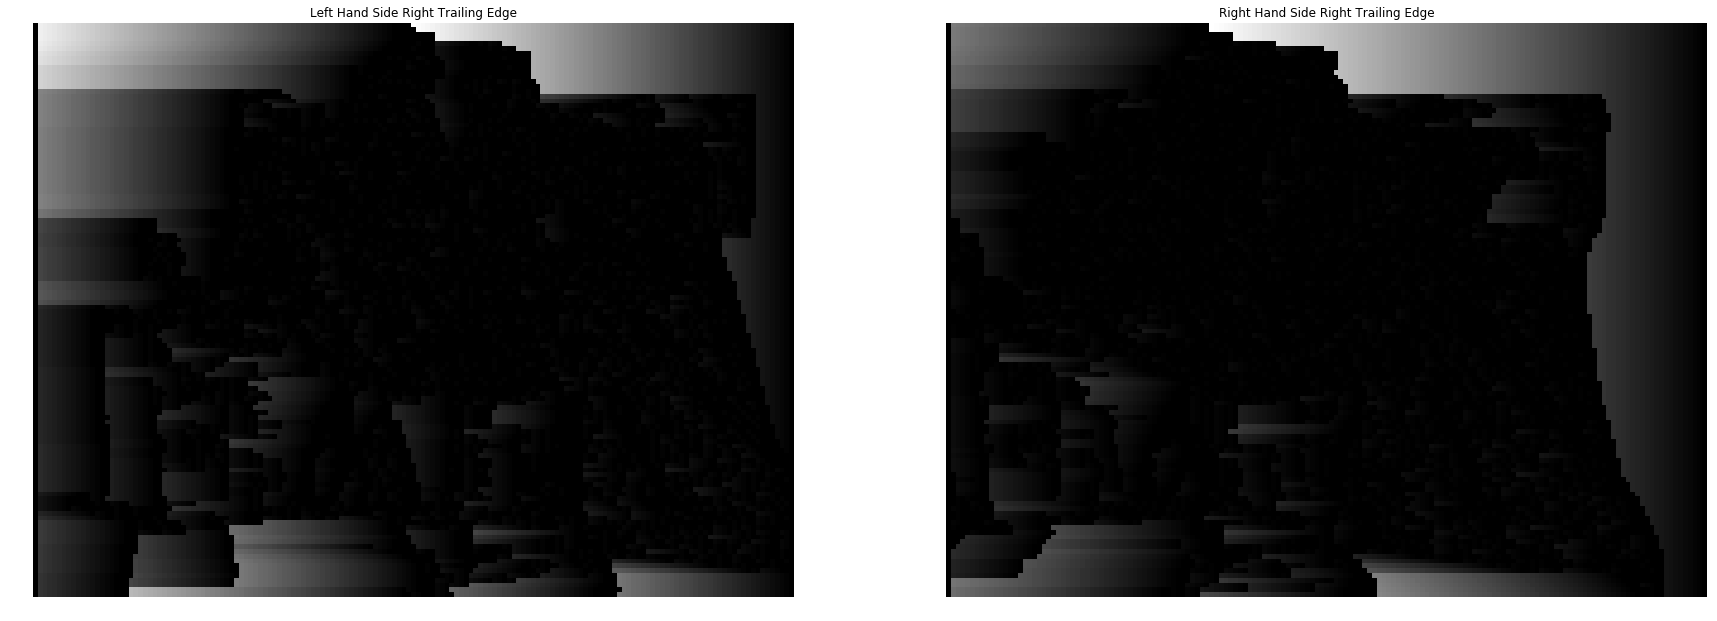

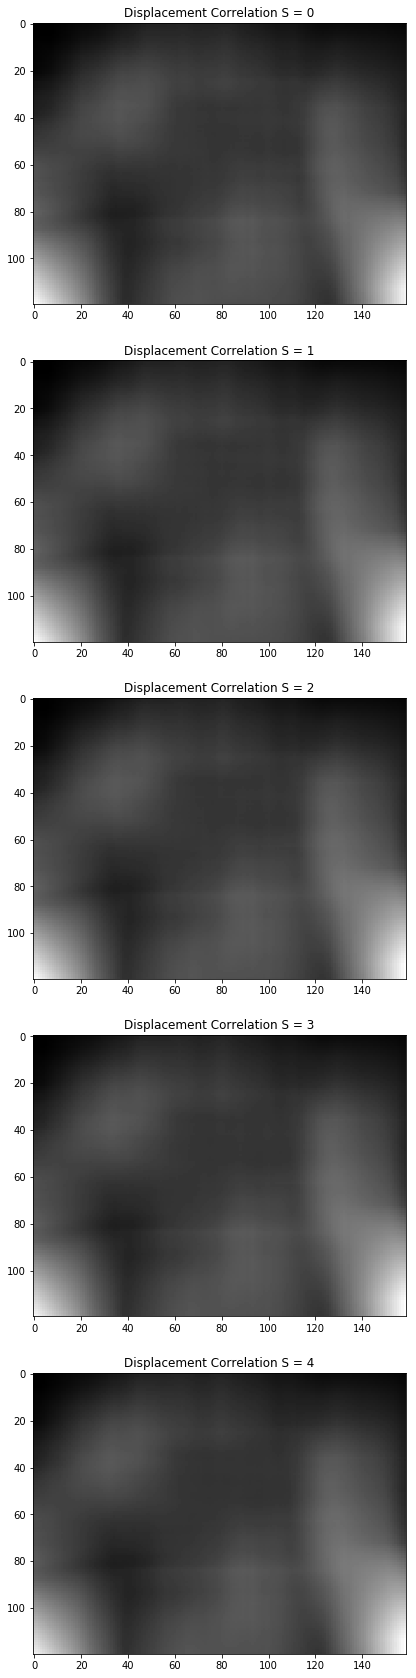

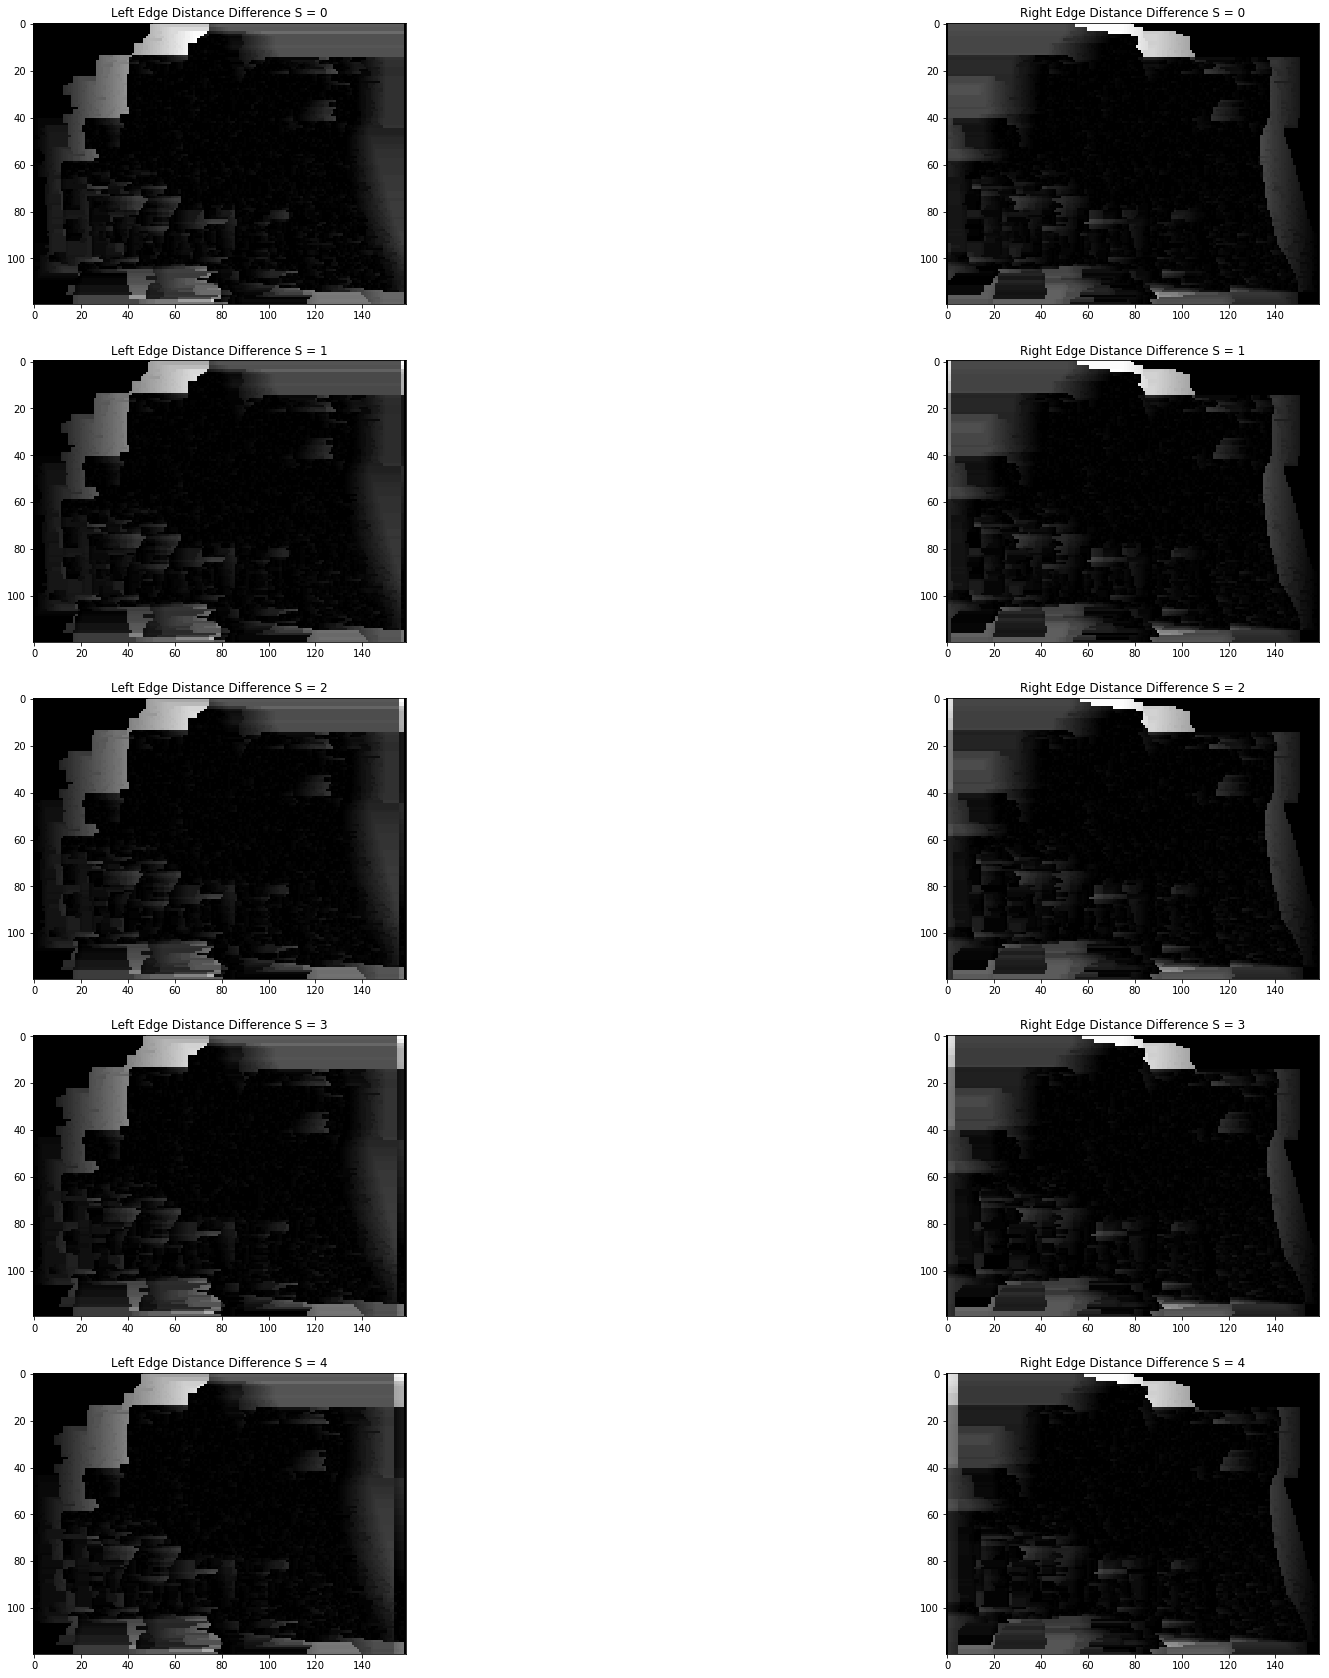

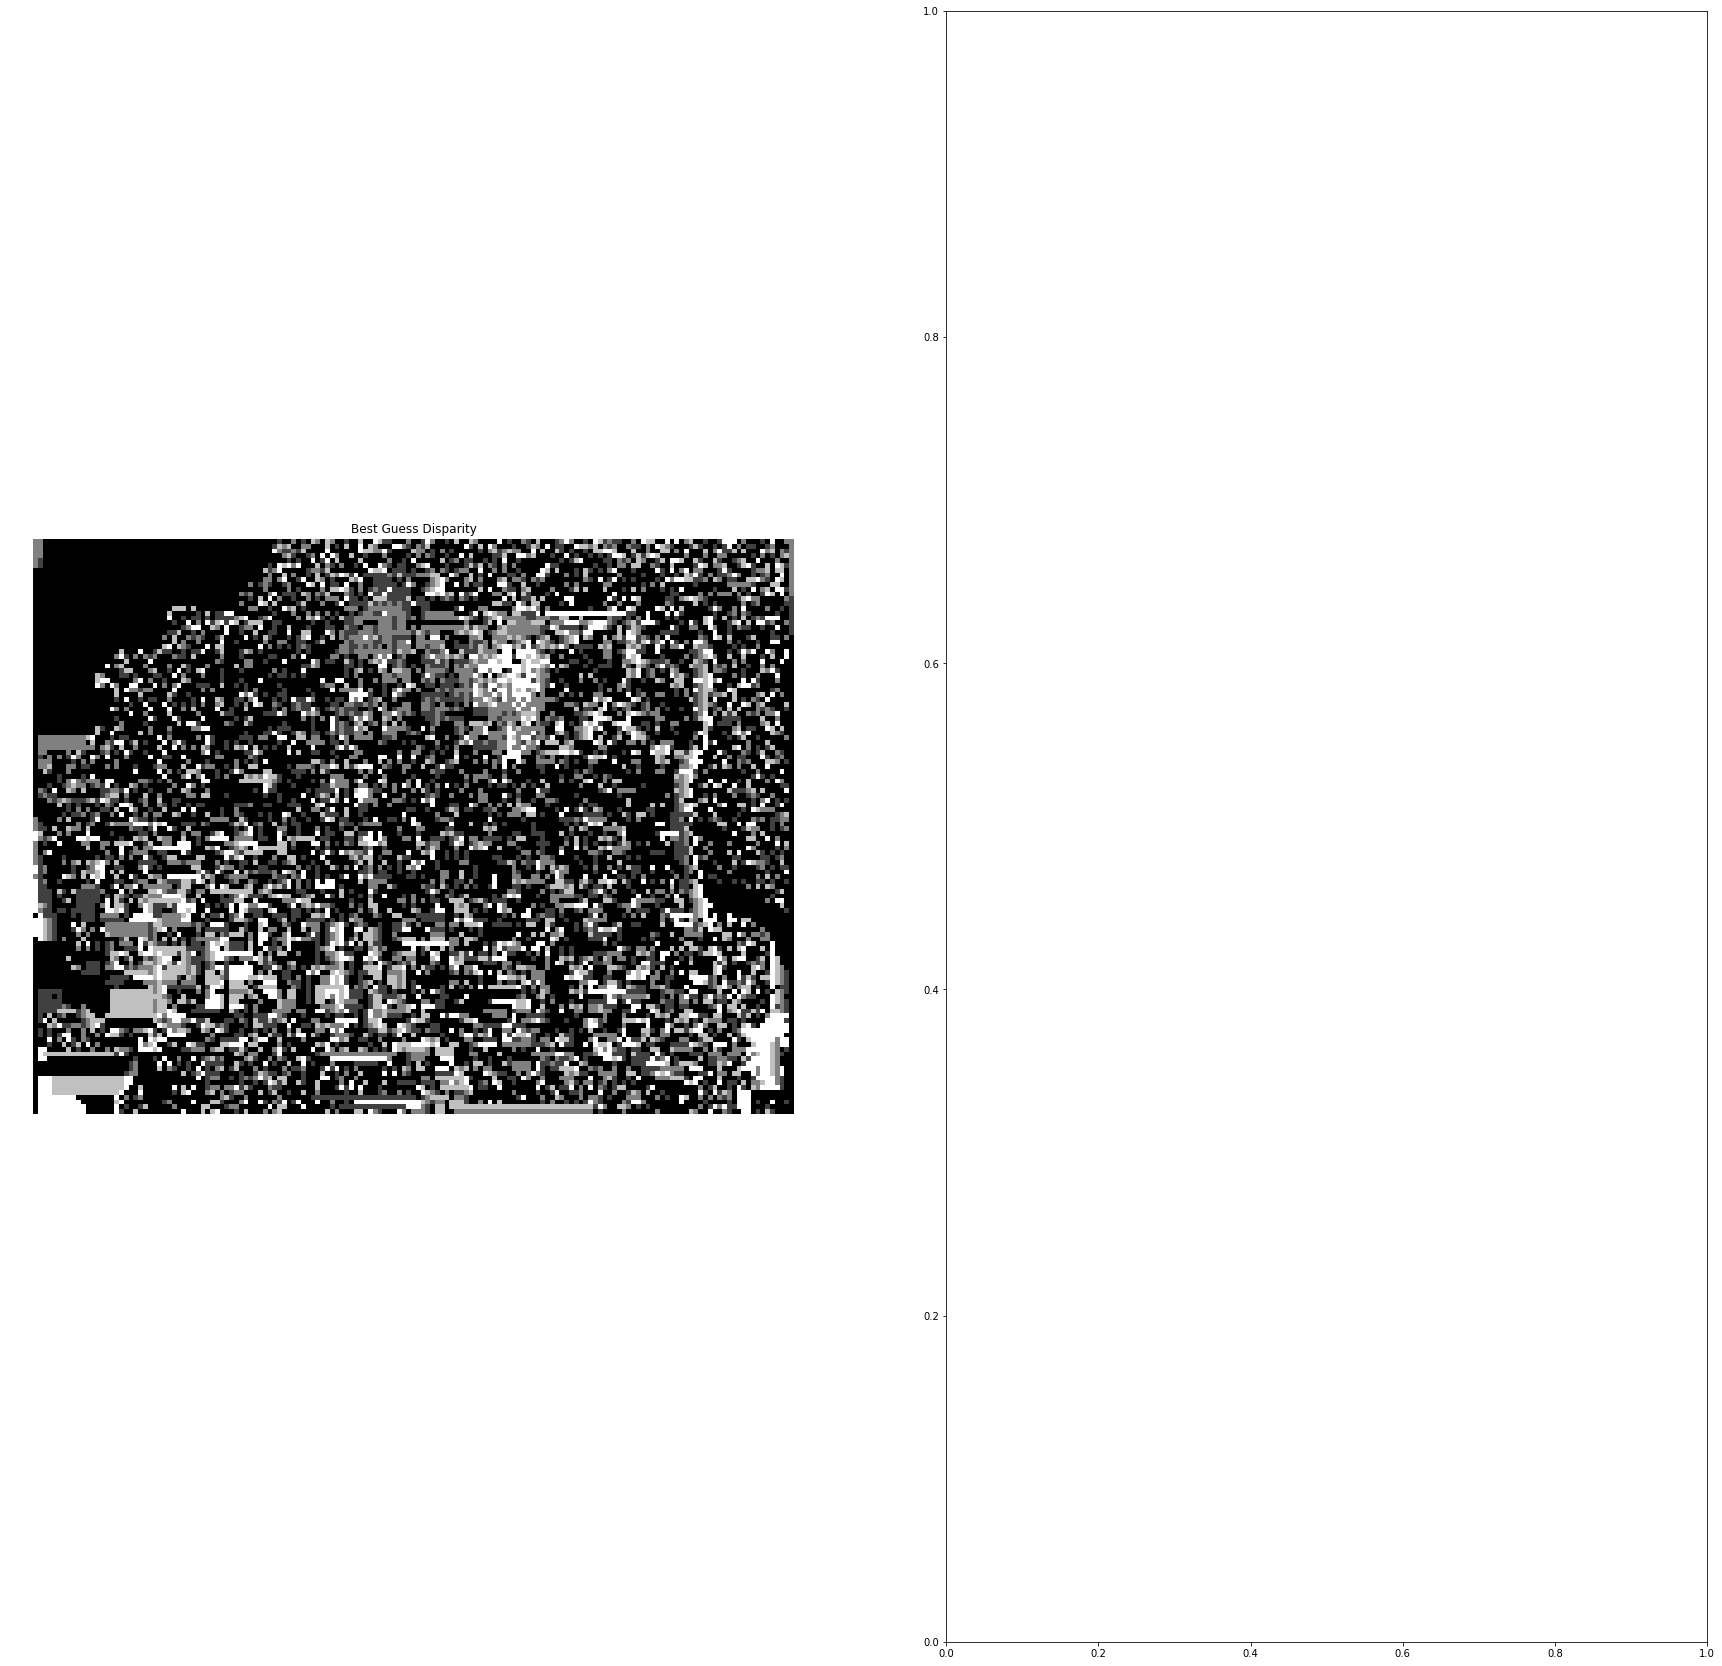

In [19]:

# ============== Image Import ==============

imageMaxDims   = [120, 240] # [540, 960]
sMax           = 5

baseImageLeft  = io.imread('data/jadePlant/im0.png').astype(float) / 255.0
baseImageRight = io.imread('data/jadePlant/im1.png').astype(float) / 255.0

baseImageLeft  = standardizedResize(baseImageLeft, imageMaxDims)
baseImageRight = standardizedResize(baseImageRight, imageMaxDims)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(baseImageLeft)
ax[0].set_title('Left Hand Side Color')
ax[0].axis('off')
ax[1].imshow(baseImageLeft)
ax[1].set_title('Right Hand Side Color')
ax[1].axis('off')

baseImageLeftGray  = rgb2grey(baseImageLeft)
baseImageRightGray = rgb2grey(baseImageRight)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(baseImageLeftGray, cmap = 'gray')
ax[0].set_title('Left Hand Side Grayscale')
ax[0].axis('off')
ax[1].imshow(baseImageLeftGray, cmap = 'gray')
ax[1].set_title('Right Hand Side Grayscale')
ax[1].axis('off')

# ============= Edge Detection =============

# > Sobel Edge Detection

baseImageLeftSobel  = SobelGradY(baseImageLeftGray)
baseImageRightSobel = SobelGradY(baseImageRightGray)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(baseImageLeftSobel, cmap = 'gray')
ax[0].set_title('Left Hand Side Sobel Y')
ax[0].axis('off')
ax[1].imshow(baseImageRightSobel, cmap = 'gray')
ax[1].set_title('Right Hand Side Sobel Y')
ax[1].axis('off')

# > Leading Edges

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(np.abs(baseImageLeftSobel) > 30.0/255.0, cmap = 'gray')
ax[0].set_title('Left Hand Side Edge Identification')
ax[0].axis('off')
ax[1].imshow(np.abs(baseImageRightSobel) > 30.0/255.0, cmap = 'gray')
ax[1].set_title('Right Hand Side Edge Identification')
ax[1].axis('off')

baseImageLeftLeadingLeft  = DistanceToLeftEdge(baseImageLeftSobel)
baseImageRightLeadingLeft = DistanceToLeftEdge(baseImageRightSobel)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(baseImageLeftLeadingLeft, cmap = 'gray')
ax[0].set_title('Left Hand Side Left Trailing Edge')
ax[0].axis('off')
ax[1].imshow(baseImageRightLeadingLeft, cmap = 'gray')
ax[1].set_title('Right Hand Side Left Trailing Edge')
ax[1].axis('off')

baseImageLeftLeadingRight  = np.flip(DistanceToLeftEdge(np.flip(baseImageLeftSobel, 1)), 1)
baseImageRightLeadingRight = np.flip(DistanceToLeftEdge(np.flip(baseImageRightSobel, 1)), 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(baseImageLeftLeadingRight, cmap = 'gray')
ax[0].set_title('Left Hand Side Right Trailing Edge')
ax[0].axis('off')
ax[1].imshow(baseImageRightLeadingRight, cmap = 'gray')
ax[1].set_title('Right Hand Side Right Trailing Edge')
ax[1].axis('off')

# ================== SAD ===================
sadDisparity = DisparityFromSAD(baseImageLeftGray, baseImageRightGray, sMax, 5)

fig, ax = plt.subplots(nrows=sMax, ncols=1, figsize=(30, 30))
for currentS in range(sMax):
    ax[currentS].imshow(sadDisparity[:, :, currentS], cmap = 'gray')
    ax[currentS].set_title("Displacement Correlation S = %d" % currentS)
    

# ============ Edge Disparities ============
leftEdgeDisparity  = DisparityForEdgeDistance(baseImageLeftGray, baseImageRightGray, sMax)
rightEdgeDisparity = np.flip(DisparityForEdgeDistance(np.flip(baseImageLeftGray, 1), np.flip(baseImageRightGray, 1), sMax), 1)

fig, ax = plt.subplots(nrows=sMax, ncols=2, figsize=(30, 30))
for currentS in range(sMax):
    ax[currentS, 0].imshow(leftEdgeDisparity[:, :, currentS], cmap = 'gray')
    ax[currentS, 0].set_title("Left Edge Distance Difference S = %d" % currentS)
    ax[currentS, 1].imshow(rightEdgeDisparity[:, :, currentS], cmap = 'gray')
    ax[currentS, 1].set_title("Right Edge Distance Difference S = %d" % currentS)
    
# ======= Computes Fuzzy Logic Results =====

disparityMap, confidence = featuresToDisparity(sadDisparity, leftEdgeDisparity, rightEdgeDisparity)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax[0].imshow(disparityMap, cmap = 'gray')
ax[0].set_title('Best Guess Disparity')
ax[0].axis('off')
#ax[1].imshow(confidence, cmap = 'gray')
#ax[1].set_title('Confidence')
#ax[1].axis('off')
print(confidence.shape)